In [1]:
import muon
import re
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
from celltypist import models
import os
os.chdir("C:\\Users\\dan94\\OneDrive - University College London\\UCL_Senior_Research_Fellow\\RIPs_Vincent_project\\samples")
os.listdir()
os.environ["R_HOME"] = "C:\\Users\\dan94\\miniconda3\\envs\\scrnaseq\\Lib\\R\\"
import rpy2
import anndata2ri #has to be version 1.1 to not throw error, so check this is the case
from rpy2.robjects import r
anndata2ri.activate()
%load_ext rpy2.ipython

cffi mode is CFFI_MODE.ANY
R home found: C:\Users\dan94\miniconda3\envs\scrnaseq\Lib\R\
Default options to initialize R: rpy2, --quiet, --no-save


In [2]:
import decoupler as dc

In [3]:
sepsis = sc.read(filename = "qiu_dataset.h5ad")

In [34]:
sepsis

AnnData object with n_obs × n_vars = 15547 × 46623
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'source', 'condition', 'donor_id', 'percent.mt', 'unintegrated_clusters', 'seurat_clusters', 'clusters', 'condition2', 'clusters_0.3', 'clusters_0.4', 'clusters_0.5', 'clusters_0.6', 'clusters_0.7', 'clusters_0.8', 'clusters_0.9', 'clusters_1.0', 'labels', 'RIP_genes1', 'status', 'sepsis_state', 'patient', 'condition_label', 'ident'
    uns: 'X_name'
    obsm: 'HARMONY', 'PCA', 'UMAP.HARMONY', 'UMAP.UNINTEGRATED'
    layers: 'counts_layer', 'logcounts'

In [4]:
#optional subsetting into populations of interest
sepsis = sepsis[sepsis.obs['labels'].isin(['Mac/mono', 'CD14+mono'])].copy()

In [5]:
sepsis.X = sepsis.layers["counts_layer"]

In [6]:
collectri = dc.op.collectri(organism='human')
collectri

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
...,...,...,...,...,...,...
42985,NFKB,hsa-miR-143-3p,1.0,ExTRI,19472311,default activation
42986,AP1,hsa-miR-206,1.0,ExTRI;GEREDB;NTNU.Curated,19721712,PMID
42987,NFKB,hsa-miR-21,1.0,ExTRI,20813833;22387281,default activation
42988,NFKB,hsa-miR-224-5p,1.0,ExTRI,23474441;23988648,default activation


In [13]:
dc.mt.ulm(data=sepsis, net=collectri)

In [14]:
score = dc.pp.get_obsm(adata=sepsis, key='score_ulm')
score

AnnData object with n_obs × n_vars = 3622 × 672
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'source', 'condition', 'donor_id', 'percent.mt', 'unintegrated_clusters', 'seurat_clusters', 'clusters', 'condition2', 'clusters_0.3', 'clusters_0.4', 'clusters_0.5', 'clusters_0.6', 'clusters_0.7', 'clusters_0.8', 'clusters_0.9', 'clusters_1.0', 'labels', 'RIP_genes1', 'status', 'sepsis_state', 'patient', 'condition_label', 'ident'
    uns: 'X_name'
    obsm: 'HARMONY', 'PCA', 'UMAP.HARMONY', 'UMAP.UNINTEGRATED', 'score_ulm', 'padj_ulm'

In [15]:
df = dc.tl.rankby_group(
    adata=score,
    groupby='condition_label',
    reference='rest',
    method='t-test_overestim_var'
)
df = df[df['stat'] > 0]
df

,group,reference,name,stat,meanchange,pval,padj
0,HC_CD14+mono,rest,VDR,67.344105,1.688750,0.000000,0.000000
1,HC_CD14+mono,rest,REL,63.046053,2.613111,0.000000,0.000000
2,HC_CD14+mono,rest,CREB1,61.184877,1.512130,0.000000,0.000000
3,HC_CD14+mono,rest,EHF,58.636482,4.167337,0.000000,0.000000
4,HC_CD14+mono,rest,ELF4,54.392700,2.449800,0.000000,0.000000
...,...,...,...,...,...,...,...
4025,S_Mac/mono,rest,ESRRB,0.021399,0.000543,0.982942,0.991302
4026,S_Mac/mono,rest,TBX3,0.020166,0.000319,0.983927,0.991302
4028,S_Mac/mono,rest,NFE2L1,0.014085,0.001418,0.988780,0.993214
4029,S_Mac/mono,rest,TBPL2,0.008931,0.000747,0.992880,0.995844


In [16]:
n_markers = 20
source_markers = (
    df
    .groupby('group')
    .head(n_markers)
    .drop_duplicates('name')
    .groupby('group')
    ['name']
    .apply(lambda x: list(x))
    .to_dict()
)
source_markers

{'HC_CD14+mono': ['VDR',
  'REL',
  'CREB1',
  'EHF',
  'ELF4',
  'IRF1',
  'ELF3',
  'DDIT3',
  'ELF5',
  'KLF9',
  'GBX2',
  'RFX1',
  'RUNX1',
  'HBP1',
  'KLF4',
  'EZH2',
  'CTNNB1',
  'TP73',
  'ETS1',
  'HMGA2'],
 'HC_Mac/mono': ['PPARG',
  'PAX6',
  'FOXP1',
  'SATB1',
  'ZXDC',
  'PLAGL1',
  'NKX2-2',
  'TCF3',
  'ETV2',
  'MYCN',
  'NR1I2',
  'TBX2',
  'TFAM',
  'HLX',
  'FOXO3',
  'PROX1',
  'HIVEP2'],
 'NS_CD14+mono': ['ZBTB14',
  'DBP',
  'GLI2',
  'MYC',
  'ZBED1',
  'ZBTB4',
  'GATA6',
  'SMARCB1',
  'SOX9',
  'KLF17',
  'ZBTB18',
  'NPM1',
  'GABPA',
  'THRB',
  'E2F4',
  'DLX2',
  'NR2F1',
  'HNF1A',
  'HEY1',
  'HOPX'],
 'NS_Mac/mono': ['SIN3A',
  'MED1',
  'PTF1A',
  'HDAC1',
  'ETV7',
  'SMARCA4',
  'BARX2',
  'PITX3',
  'TEAD1',
  'FOXG1',
  'POU2F3',
  'RUNX3',
  'HIPK2',
  'YBX3',
  'EGR4',
  'MTF1',
  'KLF15'],
 'S_CD14+mono': ['ONECUT1',
  'MYOD1',
  'CEBPE',
  'CEBPG',
  'CEBPB',
  'HIF1A',
  'ATF4',
  'CEBPA',
  'JDP2',
  'ZNF335',
  'GLI1',
  'NR1H3',
  'TBX

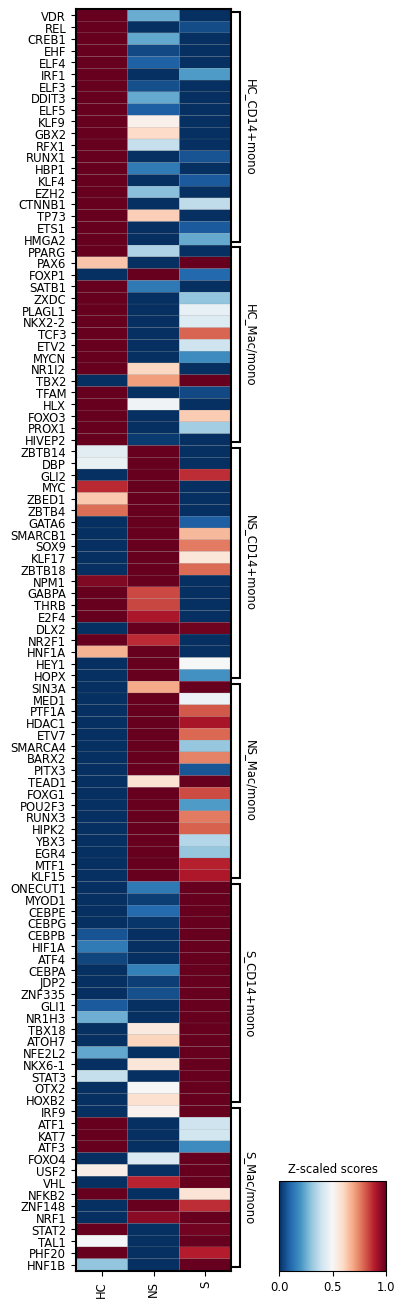

In [17]:
sc.pl.matrixplot(
    adata=score,
    var_names=source_markers,
    groupby='condition',
    dendrogram=False,
    standard_scale='var',
    colorbar_title='Z-scaled scores',
    cmap='RdBu_r',
    figsize=[4,16],
    swap_axes=True
)

In [46]:
source_markers

{'HC_CD14+mono': ['VDR',
  'REL',
  'CREB1',
  'EHF',
  'ELF4',
  'IRF1',
  'ELF3',
  'DDIT3',
  'ELF5',
  'KLF9'],
 'HC_Mac/mono': ['TP73',
  'PPARG',
  'PAX6',
  'FOXP1',
  'SATB1',
  'ZXDC',
  'PLAGL1',
  'NKX2-2',
  'TCF3',
  'ETV2'],
 'NS_CD14+mono': ['ZBTB14',
  'DBP',
  'GLI2',
  'MYC',
  'ZBED1',
  'ZBTB4',
  'GATA6',
  'SMARCB1',
  'SOX9',
  'KLF17'],
 'NS_Mac/mono': ['SIN3A',
  'MED1',
  'PTF1A',
  'HDAC1',
  'ETV7',
  'SMARCA4',
  'BARX2',
  'PITX3',
  'HOPX'],
 'S_CD14+mono': ['ONECUT1',
  'MYOD1',
  'CEBPE',
  'CEBPG',
  'CEBPB',
  'HIF1A',
  'ATF4',
  'CEBPA',
  'JDP2',
  'ZNF335'],
 'S_Mac/mono': ['TEAD1',
  'IRF9',
  'ATF1',
  'KAT7',
  'ATF3',
  'FOXO4',
  'USF2',
  'VHL']}

In [18]:
#remove HC for clarity
subset_keys = ['NS_Mac/mono', 'S_Mac/mono', 'NS_CD14+mono', "S_CD14+mono"]
subset_dict = {k: source_markers[k] for k in subset_keys}

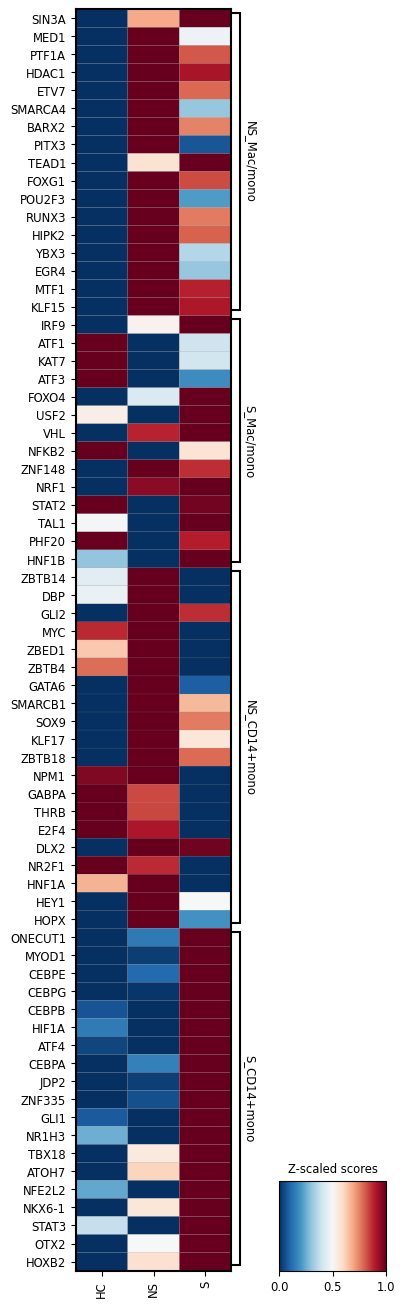

In [19]:
sc.pl.matrixplot(
    adata=score,
    var_names=subset_dict,
    groupby='condition',
    dendrogram=False,
    standard_scale="var",
    colorbar_title='Z-scaled scores',
    cmap='RdBu_r',
    figsize=[4,16],
    swap_axes=True
)

In [20]:
gex_nonclassical = sepsis[sepsis.obs["labels"] == "Mac/mono"].to_df().mean(0).to_frame().T
score_nonclassical = score[score.obs["labels"] == "Mac/mono"].to_df().mean(0).to_frame().T

In [26]:
# Group the results by 'group' and get top 10 TFs per group by 'stat'
top10_per_group = (
    df[df['stat'] > 0]                  # already done, but kept for clarity
    .sort_values(['group', 'stat'], ascending=[True, False])
    .groupby('group')
    .head(10)
)

In [28]:
# Get top 10 TFs from one group (e.g. "Fetal")
group_name = "NS_Mac/mono"

top10_sources = (
    df[df['group'] == group_name]      # Filter to one group
      .sort_values('stat', ascending=False)  # Sort by score
      .head(10)['name']              # Take top 10 sources (TFs)
      .tolist()                        # Convert to Python list
)


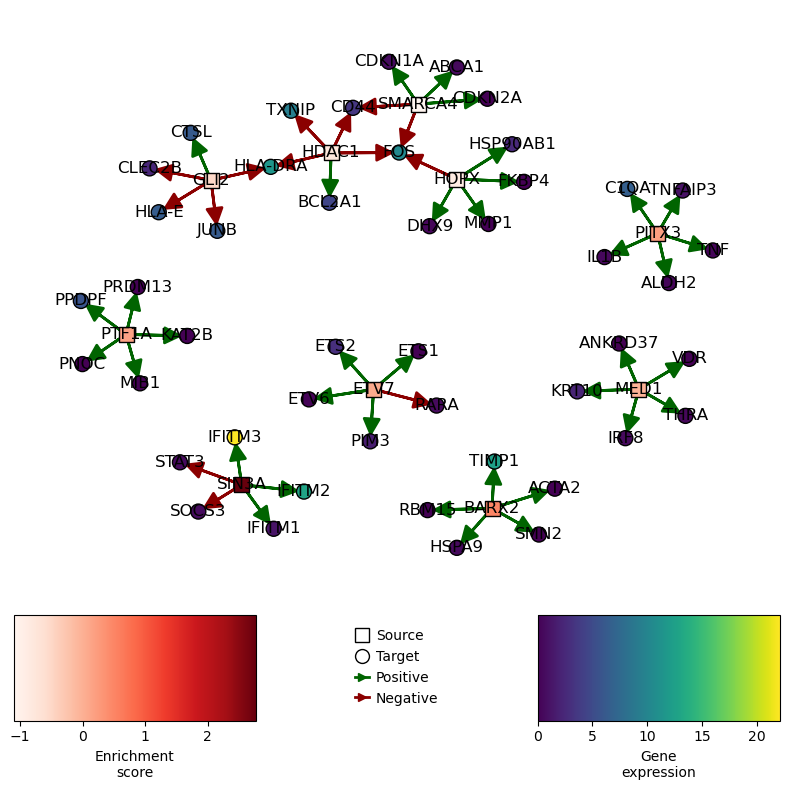

In [32]:
dc.pl.network(
    data=gex_nonclassical,
    score=score_nonclassical,
    net=collectri,
    sources=top10_sources,
    targets=5,
    size_node=10,
    figsize=(8, 8),
    s_cmap='Reds',
)